# Baseline Model for Handwritten recognition

## Imports

In [10]:
! pip install jiwer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 86.7 MB/s eta 0:00:00


In [38]:
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from jiwer import wer
import difflib
import os
import cv2
from PIL import Image
import numpy as np
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
import pandas as pd
import json
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## Loading Data




In [6]:
! unzip /content/test_bw.zip

Archive:  /content/test_bw.zip
   creating: test_bw/
  inflating: test_bw/g04-048-00.png  
  inflating: test_bw/g06-037d-07.png  
  inflating: test_bw/r06-090-01.png  
  inflating: test_bw/a04-054-01.png  
  inflating: test_bw/n01-031-07.png  
  inflating: test_bw/c01-009-03.png  
  inflating: test_bw/g06-018p-01.png  
  inflating: test_bw/p03-004-03.png  
  inflating: test_bw/e06-070-02.png  
  inflating: test_bw/b06-015-09.png  
  inflating: test_bw/l04-113-04.png  
  inflating: test_bw/e06-021-03.png  
  inflating: test_bw/c02-012-04.png  
  inflating: test_bw/c02-049-08.png  
  inflating: test_bw/f04-064-03.png  
  inflating: test_bw/b04-134-02.png  
  inflating: test_bw/b03-109-07.png  
  inflating: test_bw/d04-012-10.png  
  inflating: test_bw/m04-200-06.png  
  inflating: test_bw/m04-145-05.png  
  inflating: test_bw/a05-062-08.png  
  inflating: test_bw/g06-050k-02.png  
  inflating: test_bw/l01-105-06.png  
  inflating: test_bw/r06-090-06.png  
  inflating: test_bw/a01-058u-08

In [44]:
folder_path = '/content/test_bw'  # Replace 'folder_name' with the actual folder name

images = []
for file_name in os.listdir(folder_path):
  image_path = os.path.join(folder_path, file_name)
  image = np.array(Image.open(image_path))
  images.append(image)

images = np.array(images)
images.shape

numpy.ndarray

In [7]:
labels_head = pd.read_csv('/content/labels_500_bw.csv', sep='\t', header=None)
display(labels_head.head())
labels = labels_head.iloc[:,1].to_numpy()
labels.shape

(500,)

In [8]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=1)

In [9]:
def label_preprocessing(labels_sentence, vocabulary):
    '''
    Takes in a single label as a string (sentence matching the content of the image) and
    preprocesses it so that the label can interpreted by the model
    Param: label_sentence: the label a string
    Returns: The preprocessed label as a sequence of indexes
    '''
    max_sequence_length = max(len(sentence) for sentence in labels_sentence )

    labels_indexes = [[vocabulary[char] for char in sentence] for sentence in labels_sentence]
    preprocesed_label = pad_sequences(labels_indexes, maxlen=max_sequence_length, padding='post')

    return preprocesed_label, max_sequence_length


def get_vocabulary(train_labels):
    """
    creates a vocabulary for the translation of the prediction
    """
    vocabulary = sorted(set(''.join(train_labels)))
    vocabulary_dict = {char: index for index, char in enumerate(vocabulary)}
    return vocabulary_dict

In [11]:
vocabulary = get_vocabulary(train_labels)
train_labels_preprocessed, max_sequence_length = label_preprocessing(train_labels, vocabulary)

## Metric Functions

In [60]:
def word_error_rate(y_true, y_pred):
    """
    returns calculation of Word Error Rate for a prediction.
    """
    wer_value = wer(y_true, y_pred)
    return wer_value

def character_error_rate(y_true, y_pred):
    """
    returns calculation of Character Error Rate for a prediction.
    """
    matcher = difflib.SequenceMatcher(None, y_true, y_pred)
    cer_value = 1 - matcher.ratio()
    return cer_value

# Donut Model fine-tuning

In [4]:
!pip install transformers
!pip install sentencepiece
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.5 MB/s eta 0:00:00


<class 'PIL.PngImagePlugin.PngImageFile'>


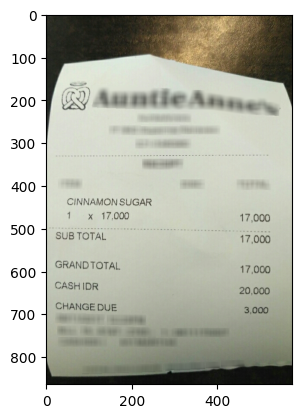

In [40]:
from datasets import load_dataset

dataset = load_dataset("hf-internal-testing/example-documents", split="test")
image = dataset[2]["image"]
print(type(image))
plt.imshow(image)




<class 'PIL.Image.Image'>


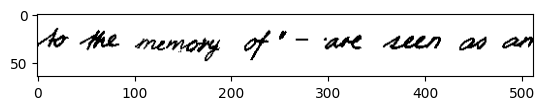

In [57]:
folder_path = '/content/test_bw'  # Replace 'folder_name' with the actual folder name

images = []
for file_name in os.listdir(folder_path):
  image_path = os.path.join(folder_path, file_name)
  image = Image.open(image_path)
  images.append(image)

image = images[3]
# Convert the image to RGB
image_rgb = image.convert("RGB")

print(type(image_rgb))
plt.imshow(image_rgb)
plt.show()


In [58]:
import re

from transformers import DonutProcessor, VisionEncoderDecoderModel
import torch
import sentencepiece
# irrelevant:
from datasets import load_dataset


processor = DonutProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = VisionEncoderDecoderModel.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2",)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print("ok")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


ok


In [59]:
# prepare decoder inputs
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids

pixel_values = processor(image_rgb, return_tensors="pt").pixel_values

outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    early_stopping=True,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    num_beams=1,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)

sequence = processor.batch_decode(outputs.sequences)[0]
sequence = sequence.replace(processor.tokenizer.eos_token, "").replace(processor.tokenizer.pad_token, "")
sequence = re.sub(r"<.*?>", "", sequence, count=1).strip()  # remove first task start token
print(processor.token2json(sequence))



{'text_sequence': ' to the memory of - are seen'}


## Prediction

In [ ]:
preds = model.predict(test_images)
index_to_char = {v: k for k, v in vocabulary.items()}
cer_sum = 0
wer_sum = 0

for i, pred in enumerate(preds):
    indices = np.argmax(pred, axis=-1)

    characters = ''.join([index_to_char[idx] for idx in indices])
    cer_sum += character_error_rate(test_labels[i], characters)
    wer_sum += word_error_rate(test_labels[i], characters)

print('CER mean: ', cer_sum / len(test_labels))
print('WER mean: ', wer_sum / len(test_labels))

84/84 [==============================] - 15s 177ms/step
CER mean:  0.8966858046624254
WER mean:  0.9569918690505834
